In [2]:
#importing numpy and pandas libraries for data operations and data loading
import numpy as np 
import pandas as pd 
#importing nltk and tensorflow preprosessing libraries for data processing and feature engineering
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#importing keras and tensorflow libraries for word embeddings and model building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D, TimeDistributed,Flatten, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import multiply
import seaborn as sns
import matplotlib.pyplot as plt
#importing libraries for splitting the data and for tracking the progress
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
#installing numpy 1.19.5 to balance with tensorflow
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Reading the training data from train.csv
train_df=pd.read_csv('train.csv')


In [4]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
#Reading the test data from test.csv
test_df=pd.read_csv('test.csv')

/Library/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
#drop unnecessary columns like id,qid1,qid2 from train data
train_df = train_df.drop(['id','qid1','qid2'],axis=1)
#drop unnecessary columns like test_id from test data
test_df = test_df.drop(['test_id'],axis=1)
train_df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
#checking for the balance of train data with is_duplicate variable 
train_df[train_df['is_duplicate']==1].shape,train_df[train_df['is_duplicate']==0].shape

((149263, 3), (255027, 3))

In [6]:
#Considering full amount of is_duplicate=1 data as it is small than is_duplicate=0
is_duplicate = train_df[train_df['is_duplicate']==1]
#considering 149260 rows of is_duplicate =0 data to maintain the balance of train data
not_duplicate = train_df[train_df['is_duplicate']==0].sample(149260)


In [7]:
#concating the is_duplicate and not_duplicate to form training data 
train_df = pd.concat([is_duplicate,not_duplicate])
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df

,question1,question2,is_duplicate
0,How do we stop terrorism permanently from root?,"How can we stop terrorism at its roots, its Id...",1
1,What are the objectives of Modi Government in ...,Can you find me a ttt?,0
2,What's the definition of a data scientist?,What is a data scientist?,1
3,What is your favourite Harry Potter movie? Why?,Which is your favourite Harry Potter movie and...,1
4,How do I invest money wisely nowadays?,Where can I learn about how to invest money wi...,1
...,...,...,...
298518,Why does Tommy Lee Jones speak such great Span...,What all exams has Ayush Bansal cleared? He sa...,0
298519,How can you speak and learn fluent English lik...,How can I learn to speak English fluently?,1
298520,What are the differences between primary memor...,"In a computer, what is the difference between ...",1
298521,How is duck sauce created?,How can you make duck sauce?,1


In [12]:
# Defining a POS function to categorize the text to a particular parts of speech
def pos(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()#Used Wordnet Lemmatizer to group different inflicted forms of a word together.

In [13]:
# Stacking up all the stopwords in english language 
STOPWORDS = set(stopwords.words('english'))

# Defining a clean text method
def clean_text(text):
    text = text.lower() #Converting the text to lower case.
    text = re.compile(r'<[^>]+>').sub(' ', text) #Replacing HTML tags with blank space
    text = re.compile(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+').sub('', text)#URLS
    text = re.compile(r'#(\w+)').sub('', text)#Replacing Hash tags  with blank space
    text = re.compile(r'@(\w+)').sub('', text)#Replacing @ tags with blank space
    text = re.compile(r"[^a-z0-9\-]").sub(' ', text)#Replacing unwanted words with blank space 
    
    
    
    for word in text.split():
        if word not in STOPWORDS and len(word)>3:
            text = " ".join(lemmatizer.lemmatize(word.strip(), pos(pos_tag([word.strip()])[0][1])))
            #filters and return the text after removing stopwords, lemmatization and pos tags
    
    return text

In [15]:
#Droping out null values 
train_df = train_df.dropna()

In [16]:
# applyiing the clean_text function to question1 in train data 
train_df['q1'] = train_df['question1'].apply(clean_text)


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
import nltk

In [18]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [19]:
#Droping out null values
test_df = test_df.dropna()

In [20]:
# applyiing the clean_text function to question2 in train data 
train_df['q2'] = train_df['question2'].apply(clean_text)

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:

train_df['q1']

0                     accord corrupt indian politician ever
1                        delete quora primary email address
2                             education system change india
3                        different type job technical field
4                            need digital marketing service
                                ...                        
298518                                      increase height
298519                                 clear bank exam 12th
298520    difference synchronous asynchronous data transfer
298521                                 best traffic website
298522                                                 feel
Name: q1, Length: 298522, dtype: object

In [23]:

#calling Tokenizer 
tokenizer = Tokenizer(num_words = 200000)
#Updates internal vocabulary based on list of texts
tokenizer.fit_on_texts(list(train_df['q1'].values.astype(str))+list(train_df['q2'].values.astype(str)))

#Transforms each text in question1 texts in training data to a sequence of integers and pads each sequence to attain a max_len of 30
X_train_q1 = tokenizer.texts_to_sequences(train_df['q1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding = 'post')
#Transforms each text in question2 texts in training data to a sequence of integers and pads each sequence to attain a max_len of 30
X_train_q2 = tokenizer.texts_to_sequences(train_df['q2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding = 'post')

In [24]:
# applyiing the clean_text function to question1 in test data 
test_df['q1'] = test_df['question1'].apply(clean_text)
# applyiing the clean_text function to question2 in test data 
test_df['q2'] = test_df['question2'].apply(clean_text)
test_df.head()

,question1,question2,q1,q2
0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,surface compare ipad,microsoft choose core core home surface
1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,hair transplant much would cost,much cost hair transplant require
2,What but is the best way to send money from Ch...,What you send money to China?,best send money china,send money china
3,Which food not emulsifiers?,What foods fibre?,food emulsifier,food fibre
4,"How ""aberystwyth"" start reading?",How their can I start reading?,aberystwyth start reading,start reading


In [25]:
#Transforms each text in question1 texts in test data to a sequence of integers and pads each sequence to attain a max_len of 30
X_test_q1 = tokenizer.texts_to_sequences(test_df['q1'].ravel())
X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')
#Transforms each text in question2 texts in test data to a sequence of integers and pads each sequence to attain a max_len of 30
X_test_q2 = tokenizer.texts_to_sequences(test_df['q2'].astype(str).ravel())
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [26]:
e_index = {}
#Loading glove file with 200 dimesions 
glove = open('glove.6B.200d.txt','r',encoding='utf-8')
for line in tqdm(glove):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    # finding number of word vectors
    e_index[word] = coefs
glove.close()

print('Found %s word vectors.' % len(e_index))

400000it [00:13, 29403.13it/s]

Found 400000 word vectors.


In [27]:
#Initializing  embedding matrix 
e_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
#Creating embedding matrix
for words, index in tqdm(tokenizer.word_index.items()):
    #loading word vectors into embedding vector 
    e_vector = e_index.get(word)
    if e_vector is not None:
        e_matrix[index] = e_vector

100%|█████████████████████████████████| 55239/55239 [00:00<00:00, 706671.01it/s]


In [28]:
y = train_df['is_duplicate']

In [29]:
#splitting the data 
X_train_q1,X_valid_q1, X_train_q2, X_valid_q2, y_train, y_valid = train_test_split(X_train_q1, X_train_q2, y, test_size=0.20, random_state=12)
print(X_train_q1.shape, X_train_q2.shape, y_train.shape)
print(X_valid_q1.shape, X_valid_q2.shape, y_valid.shape)

(238817, 30) (238817, 30) (238817,)
(59705, 30) (59705, 30) (59705,)


In [30]:
vocab_size = len(tokenizer.word_index) + 1

In [31]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [32]:
#Defining the question1 model with embedding layer ,3 LSTM layers and 2 fully connected dense layers 
model_q1 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [e_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

2022-04-12 12:46:18.080932: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 12:46:18.083203: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [33]:
#Defining the question2 model with embedding layer ,3 LSTM layers and 2 fully connected dense layers 
model_q2 = Sequential([Embedding(input_dim = vocab_size,output_dim = 200,weights = [e_matrix],input_length = 30),
                      LSTM(128, activation = 'tanh', return_sequences = True),
                      Dropout(0.2),
                      LSTM(128, return_sequences = True),
                      LSTM(128),
                      Dense(60, activation = 'tanh'),
                      Dense(2, activation = 'sigmoid')])

In [36]:
#combing the q1 and q2 models for the final model 
mergedOut = multiply([model_q1.output, model_q2.output])
#Further adding few more dense layers with relu and sigmoid activation functions for merged model 
mergedOut = Flatten()(mergedOut)
mergedOut = Dense(100, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(50, activation = 'relu')(mergedOut)
mergedOut = Dropout(0.2)(mergedOut)
mergedOut = Dense(2, activation = 'sigmoid')(mergedOut)

In [37]:
#Building the defined model with keras and adam optimizer 
new_model = tf.keras.Model([model_q1.input, model_q2.input], mergedOut)
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])

In [38]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_1_input (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      11048000    embedding_input[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      11048000    embedding_1_input[0][0]          
______________________________________________________________________________________________

In [45]:
#Converting the data into numpy arrays
X_train_q1 = np.array(X_train_q1)
X_train_q2 = np.array(X_train_q2)
X_valid_q1 = np.array(X_valid_q1)
X_valid_q2 = np.array(X_valid_q2)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [47]:
#Training the model with the training and validation data for  20 epochs 
history = new_model.fit([X_train_q1,X_train_q2],y_train, batch_size = 2000, epochs = 20, validation_data = ([X_valid_q1,X_valid_q2],y_valid))


Train on 238817 samples, validate on 59705 samples
Epoch 1/20
238817/238817 [==============================] - 6432s 27ms/sample - loss: 0.2870 - accuracy: 0.8726 - val_loss: 0.7023 - val_accuracy: 0.7259
Epoch 2/20
238817/238817 [==============================] - 2904s 12ms/sample - loss: 0.2740 - accuracy: 0.8786 - val_loss: 0.7152 - val_accuracy: 0.7286
Epoch 3/20
238817/238817 [==============================] - 2019s 8ms/sample - loss: 0.2623 - accuracy: 0.8850 - val_loss: 0.7645 - val_accuracy: 0.7318
Epoch 4/20
238817/238817 [==============================] - 5961s 25ms/sample - loss: 0.2532 - accuracy: 0.8897 - val_loss: 0.7831 - val_accuracy: 0.7245
Epoch 5/20
238817/238817 [==============================] - 2058s 9ms/sample - loss: 0.2424 - accuracy: 0.8949 - val_loss: 0.7952 - val_accuracy: 0.7295
Epoch 6/20
238817/238817 [==============================] - 2015s 8ms/sample - loss: 0.2354 - accuracy: 0.8982 - val_loss: 0.8372 - val_accuracy: 0.7290
Epoch 7/20
238817/238817 [==

In [ ]:
history.save('model')

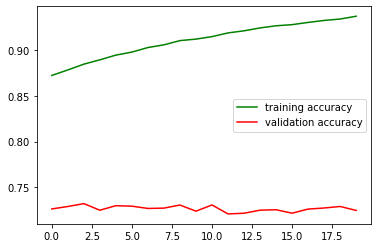

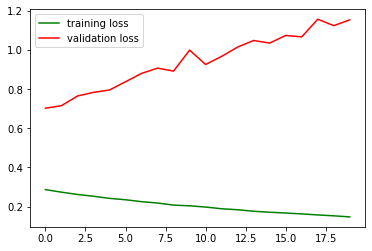

In [49]:
# obtaining  the  accuracy and loss for training 
accuracy = history.history["accuracy"]
loss = history.history["loss"]
# obtaining  the  accuracy and loss for validation
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plotting the accuracy for training and validation
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()

#plotting the loss for training and validation
plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()


In [50]:
#predicting the test data with trained model
y_pred = new_model.predict([X_test_q1, X_test_q2])

2022-04-13 20:10:17.943944: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_36567_specialized_for_model_lstm_StatefulPartitionedCall_at___inference_distributed_function_38795' and '__inference_cudnn_lstm_with_fallback_36678' both implement 'lstm_ed97c592-e95a-48a1-94e5-b6acadc63e36' but their signatures do not match.


In [53]:
np.argmax(y_pred[:10], axis=-1)  

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0])

In [51]:
#saving the model 
new_model.save('model1')

2022-04-14 07:07:16.032158: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model1/assets


In [54]:
new_model.save('model1.h5')